In [102]:
import sqlite3
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import itertools as it

#print(mp.__version__)

%matplotlib inline

In [4]:
def select_by(db, name, type):

    S = """select s1.ts,s1.type,s1.tid,s1.iter,(s2.ts-s1.ts),s1.heap,s2.heap,s1.details
  from stats s1 inner join stats s2 on s1.tid=s2.tid and s1.iter=s2.iter and s1.action!=s2.action and s1.type=s2.type
 where s1.type='{type}' and s1.action='start' and s1.name = '{name}' and s2.name = '{name}'
 order by s1.ts asc;"""
    cur = db.cursor()
    r = []
    #print S.format(type=type, name=name)
    for row in cur.execute(S.format(type=type, name=name)):
        r.append(row)
    return r

def csv(a):
    for i in a:
        print ",".join(str(x) for x in i)

In [5]:
def load_data_set(name):
    db = sqlite3.connect("stats.sql")
    DS = ''
    a = select_by(db, name, 'compute')
    b = select_by(db, name, 'gc')
    #c = a + b
    #c.sort(key=lambda a: a[0])
    #csv(c)
    db.close()
    return a,b


In [104]:
def gen_graph(name='20170430-hask-p9', W=100, B=30, 
              FS=18, 
              HEAP=True, CTLOG=True, HEAPLOG=True,
              CTLO=(0,0), HEAPLO=(0,0),
              XDIV=10^3, YDIV=10^3):
    """
    W = width of graph (number of data points to include)
    B = cut off when GC thread kicks in (usually around the 30th data point
        but you should inspect the "raw" file and count the number of "comp:start"
        entries until you see the first "gc:start" and use that count as B.)
    FS = font size for axis labels/title
    HEAP = T|F show heap line on chart
    CTLOG = T|F apply log scale to compute thread line
    HEAPLOG = T|F apply log scale to heap line
    CTLO = (δx,δy) tuple allowing for adjustment of compute stats (mu/sigma label)
    HEAPLO = (δx, δy) tuple allow for adjustment of heap stats (mu/sigma label)
    """
    # haskell time is in us .. div by 1000 for ms
    a, b = load_data_set(name)

    xs = [(x[0]-a[0][0])/(XDIV) for x in a]
    ys = [x[4]/(YDIV) for x in a]
    heapys = [(x[5]/(1024*1024)) for x in a]

    #for i, v in enumerate(ys[:W]):
    #    print i, v

    W_ = W - B
    mean0, mean1 = np.mean(ys[:B]), np.mean(ys[B:W_])
    std0, std1 = np.std(ys[:B]), np.std(ys[B:W_])
    #print mean0, std0
    #print mean1, std1
    #print xs[:10]

    L0 = "RT/-MP\n$\mu$={0:.2f},\n$\sigma={1:.2f}$".format(mean0, std0)
    L1 = "RT/+MP\n$\mu$={0:.2f},\n$\sigma={1:.2f}$".format(mean1, std1)

    fig, ax1 = plt.subplots(dpi=120, figsize=(7,7))
    ax2 = ax1.twinx()
    ax1.plot(xs[:W], ys[:W], 'bo', markerfacecolor='none')
    if CTLOG is True:
        ax1.set_yscale('log')
    if HEAP is True:
        ax2.plot(xs[:W], heapys[:W], 'r-', alpha=0.5)
    if HEAPLOG is True:
        ax2.set_yscale('log')

    ax1.set_xlabel(r"Delta Interation Start Time ($ms$)", fontsize=FS)
    ax1.set_ylabel("Run Time ($ms$)", color='blue', fontsize=FS)
    ax2.set_ylabel("Heap Used ($Mbytes$)", color='red', fontsize=FS)
    #plt.plot(xs[:W], ys[:W], 'bs')
    try:
        # *XDIV doesnt do what I expected so I left it out for now
        ax1.text(0.0 + CTLO[0]*XDIV, mean0*2 + CTLO[1], L0)
        ax1.text(xs[50] + HEAPLO[0]*XDIV, mean1 + HEAPLO[1], L1)
    except Exception as e:
        print "Failed to place mu/sigma text: ", e

    ax1.set_title(a[0][7], fontsize=FS)

    xs_ = np.array(xs)
    ys_ = np.array(ys)
    heapys_ = np.array(heapys)
    print name
    print "xs_ ", np.shape(xs_), np.min(xs_), np.max(xs_)
    print "ys_ ", np.shape(ys_), np.min(ys_), np.max(ys_)
    print "hp  ", np.shape(heapys_), np.min(heapys_), np.max(heapys_)
    print "xs_30 ", xs_[B-1]
    
    sub = fig.gca()
    sub.add_patch(
        patches.Rectangle(
            (np.min(xs_), np.min(heapys_)), #(-1e6, 0),      # (x,y)
            xs_[B],                         # 1e6 + 3*10**6, # width
            np.max(heapys_),                # 700            # height
            alpha=0.1, facecolor="#555555"
        )
    )
    sub.add_patch(
        patches.Rectangle(
            (xs_[B], np.min(heapys_)), # (3*10**6, 00), # (x,y)
            np.max(xs_), # 1.2*10**7,     # width
            np.max(heapys_), #6000,          # height
            alpha=0.1, facecolor="#AAAAAA"
        )
    )
    
    pp = PdfPages("{}.pdf".format(name))
    pp.savefig(fig)
    pp.close()

20170430-hask-p9
xs_  (1100,) 0.0 148135089.444
ys_  (1100,) 556.333333333 101720.444444
hp   (1100,) 0 868
xs_30  3241716.0
20170430-hask-gcb
xs_  (1100,) 0.0 144263842.333
ys_  (1100,) 555.777777778 221739.444444
hp   (1100,) 0 1533
xs_30  3353817.0


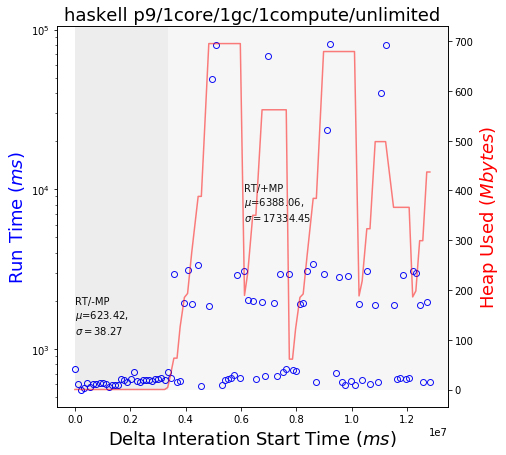

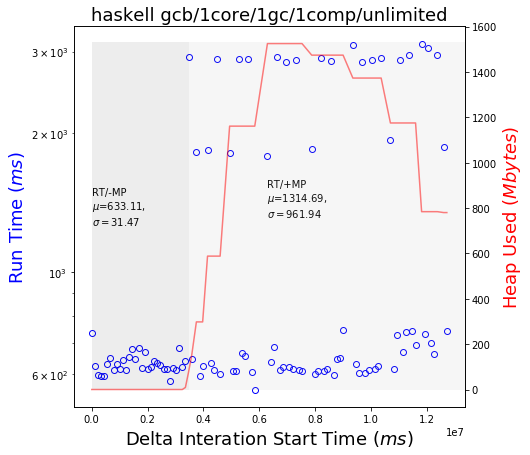

In [105]:
gen_graph(name='20170430-hask-p9', W=100, FS=18, HEAPLOG=False)
gen_graph(name='20170430-hask-gcb', W=100, B=31, FS=18, HEAPLOG=False)


20170511-cloj-p9
xs_  (1100,) 0.0 282659.0
ys_  (1100,) 100.666666667 197.444444444
hp   (1100,) 6 62
xs_30  3285.66666667
20170509-cloj-gcb.txt
xs_  (1100,) 0.0 204477.333333
ys_  (1100,) 27.5555555556 590.555555556
hp   (1100,) 2869 6536
xs_30  3307.0


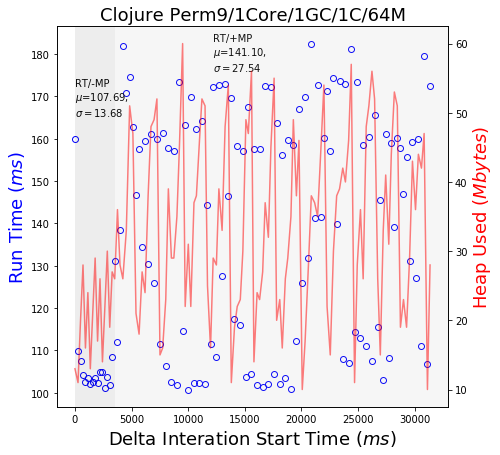

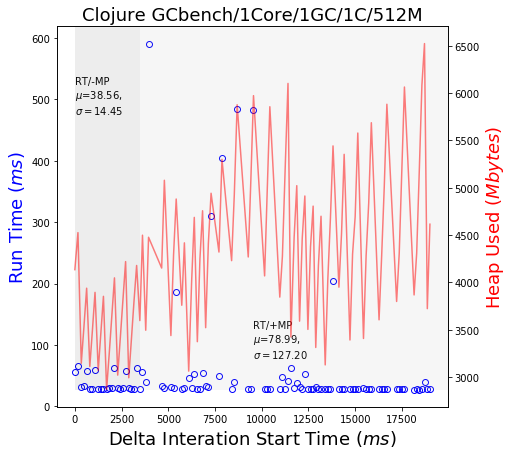

In [115]:
gen_graph(name='20170511-cloj-p9', W=125, B=16, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,-50), HEAPLO=(0,35))
gen_graph(name='20170509-cloj-gcb.txt', W=100, B=23, FS=18, HEAP=True, CTLOG=False, HEAPLOG=False, CTLO=(0,400))